
# Stage 2 – Time Series Anomaly Detection on SMD (ServerMachineDataset)

This notebook implements **Stage 2 – Application of Data Mining Techniques** for a multivariate
time series anomaly detection project, using the **ServerMachineDataset (SMD)** from the
OmniAnomaly repository:

> https://github.com/NetManAIOps/OmniAnomaly/tree/master/ServerMachineDataset

We work with **one machine at a time** (e.g. `machine-1-1`), exactly as in your EDA code,
and we do **not** need to load the entire dataset into memory.

The pipeline is aligned with the KDD process:

1. **Data preparation**
   - Load SMD train / test files for one machine
   - Normalize features using training statistics
   - Build sliding windows (temporal context)
2. **Modeling**
   - Mean reconstruction baseline
   - LSTM autoencoder
   - Transformer-based autoencoder (TranAD-inspired, simplified)
3. **Evaluation**
   - Reconstruction-based anomaly scores
   - Thresholding via high-quantile on training errors
   - Precision, Recall, F1, ROC-AUC, PR-AUC (if labels are available)


# Notebook Outline

# 1. Setup & Utilities

## 1.1 Imports

## 1.2 Reproducibility (Seeds)

## 1.3 Helper Functions
- plotting utilities  
- metrics (precision, recall, F1, AUCs)  
- segment cleaning  
- smoothing  
- scoring utilities  

---

# 2. Data Loading & Preprocessing

## 2.1 Load SMD (machine-1-1)

## 2.2 Normalisation

## 2.3 Sliding Window Segmentation
- K = 10
- K = 30
- K = 50

---

# 3. Baseline Models

## 3.1 Mean Reconstruction Baseline

## 3.2 LSTM Autoencoder

## 3.3 Transformer AE (LN + MSE)

## 3.4 Transformer AE (LN + Huber)

---

# 4. Training Results

## 4.1 Training & Validation Loss Curves
*(corresponds to Figure 8 in the report)*

## 4.2 Reconstruction Error Distributions
*(Figure 9 of the report)*

## 4.3 Ablation Study: Effect of Window Size K

## 4.4 Ablation Study: MSE vs Huber

---

# 5. Anomaly Scoring & Thresholding

## 5.1 Reconstruction Scores (train/test)

## 5.2 Thresholding Methods
- Quantile (q = 0.995)
- Std-boost (μ + 3σ)

## 5.3 Score Smoothing
- moving average window = 5

---

# 6. Performance Evaluation

## 6.1 Timestamp-Level Metrics (Precision, Recall, F1)

## 6.2 Error Type Decomposition (TP, FP, FN)
*(matches Table in Section 6.6 of the report)*

## 6.3 ROC and PR Curves

## 6.4 Interpretation of Baseline Behaviour

---

# 7. Numerical Instabilities

## 7.1 Identifying Extreme Outliers (~480 windows)

## 7.2 Value Range Before/After Filtering

## 7.3 Understanding the Source
- LayerNorm  
- residual connections  
- attention patterns  

*(matches Section 7 of the report)*

---

# 8. Refinement Experiments

## 8.1 Motivation
*(reference Sections 6–7 of the report)*

## 8.2 Threshold Tuning Experiments
- raw vs smoothed  
- quantile vs std-boost  

## 8.3 Segment Cleaning (min length = 3)

## 8.4 Self-Conditioned Scoring (moving window focus)

## 8.5 Semi-Adversarial Training
- synthetic anomalies  
- margin loss  

## 8.6 Combined Refinements

## 8.7 Precision–Recall Comparison
*(corresponds to Figure 10 of the report)*

## 8.8 Final Refined Metrics
*(corresponds to Table 7 of the report)*

---

# 9. Qualitative Diagnostics

## 9.1 Zoomed Reconstruction Behaviour
*(Figure 11)*

## 9.2 Feature-level Heatmap
*(Figure 12)*

---

# 10. Cross-Machine Generalisation

## 10.1 Multi-machine Transformer Training

## 10.2 Per-machine Evaluation

## 10.3 Interpretation and Limitations
*(matches Section 10 of the report)*

---

# 11. Summary of Findings

## 11.1 Best Models

## 11.2 Key Limitations

## 11.3 Why SOTA (TranAD, OmniAnomaly) Performs Better

## 11.4 What Refinements Helped & What Didn't

---

# 12. Appendix (optional)

## 12.1 Full Hyperparameters  
## 12.2 Model Architecture Diagrams  
## 12.3 Raw Plots  


## 1. **Setup & Configuration**

In [ ]:

import os
from typing import Tuple, Optional, Dict
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Helper function for sinusoidal positional encoding
def sinusoidal_pos_encoding(max_len, d_model):
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0) # (1, max_len, d_model)


Using device: cpu


## 2. **SMD Data Loading**<a id='data-loading'></a>

The original **SMD** structure (from the OmniAnomaly repo) is:

- `ServerMachineDataset/train/machine-x-y.txt` – training data (normal only)
- `ServerMachineDataset/test/machine-x-y.txt` – test data (with anomalies)
- `ServerMachineDataset/test_label/machine-x-y.txt` – test labels (0 = normal, 1 = anomaly)
- `ServerMachineDataset/interpretation_label/machine-x-y.txt` – detailed feature-level anomaly info

We define a loader that:

1. Reads the `train` and `test` `.txt` files for a single machine.
2. Optionally reads `test_label` if available to build a 0/1 label vector.
3. Returns NumPy arrays `(train_data, test_data, test_labels)`.


### 2.1 SMD Data Loading (single machine)

In [ ]:
import os

# elenco macchine (dal README OmniAnomaly)
files = [f"machine-{i}-{j}.txt"
         for i, j in [(1,k) for k in range(1,9)] +
                      [(2,k) for k in range(1,10)] +
                      [(3,k) for k in range(1,10)]]

# --- TRAIN ---
base_url_train = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/"
os.makedirs("data/ServerMachineDataset/train", exist_ok=True)

for fname in files:
    url = base_url_train + fname
    out = f"data/ServerMachineDataset/train/{fname}"
    if not os.path.exists(out):
        print("Downloading train:", url)
        !wget -q {url} -O {out}

# --- TEST ---
base_url_test = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test/"
os.makedirs("data/ServerMachineDataset/test", exist_ok=True)

for fname in files:
    url = base_url_test + fname
    out = f"data/ServerMachineDataset/test/{fname}"
    if not os.path.exists(out):
        print("Downloading test :", url)
        !wget -q {url} -O {out}

# --- TEST LABEL ---
base_url_label = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test_label/"
os.makedirs("data/ServerMachineDataset/test_label", exist_ok=True)

for fname in files:
    url = base_url_label + fname
    out = f"data/ServerMachineDataset/test_label/{fname}"
    if not os.path.exists(out):
        print("Downloading label:", url)
        !wget -q {url} -O {out}

# --- INTERPRETATION LABEL (per feature-level diagnosis) ---
base_url_interp = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/interpretation_label/"
os.makedirs("data/ServerMachineDataset/interpretation_label", exist_ok=True)

for fname in files:
    url = base_url_interp + fname
    out = f"data/ServerMachineDataset/interpretation_label/{fname}"
    if not os.path.exists(out):
        print("Downloading interp:", url)
        !wget -q {url} -O {out}


In [ ]:
from pathlib import Path

def load_smd_machine(
    train_dir: str,
    machine_id: str = "machine-1-1",
    test_dir: str = None,
    label_dir: str = None,
):
    """
    Load SMD data for a single machine, using the same folder structure
    you already used in your EDA notebook.

    Parameters
    ----------
    train_dir : str
        Folder that contains the training .txt files, e.g. "data/ServerMachineDataset/train".
    machine_id : str
        Machine identifier, e.g. "machine-1-1".
    test_dir : str, optional
        Folder that contains the test .txt files. If None, defaults to parent of train_dir / "test".
    label_dir : str, optional
        Folder that contains the test_label .txt files. If None, defaults to parent of train_dir / "test_label".

    Returns
    -------
    train_data : np.ndarray (T_train, D)
    test_data  : np.ndarray (T_test, D) or None if test file not found
    test_labels : np.ndarray (T_test,) or None if label file not found
    """
    train_dir = Path(train_dir)

    if test_dir is None:
        test_dir = train_dir.parent / "test"
    else:
        test_dir = Path(test_dir)

    if label_dir is None:
        label_dir = train_dir.parent / "test_label"
    else:
        label_dir = Path(label_dir)

    train_path = train_dir / f"{machine_id}.txt"
    test_path = test_dir / f"{machine_id}.txt"
    label_path = label_dir / f"{machine_id}.txt"

    if not train_path.exists():
        raise FileNotFoundError(f"Train file not found: {train_path}")

    train_df = pd.read_csv(train_path, header=None)
    train_data = train_df.values.astype(np.float32)

    print(f"Loaded SMD machine {machine_id}")
    print("Train shape:", train_data.shape)

    # Test may or may not exist
    if test_path.exists():
        test_df = pd.read_csv(test_path, header=None)
        test_data = test_df.values.astype(np.float32)
        print("Test  shape:", test_data.shape)
    else:
        print(f"⚠️ Test file not found: {test_path} – using None.")
        test_data = None

    # Labels may or may not exist
    if label_path.exists():
        labels_df = pd.read_csv(label_path, header=None)
        test_labels = labels_df.values.squeeze().astype(int)
        print("Labels shape:", test_labels.shape)
        print("Number of anomalous points in test:", int(test_labels.sum()))
    else:
        print(f"⚠️ Label file not found: {label_path} – using None.")
        test_labels = None

    return train_data, test_data, test_labels


### 2.2-3. **Preprocessing: Normalization & Sliding Windows**<a id='preprocessing'></a>

We now:

1. **Normalize** each feature using **min-max normalization** (based only on the training set):
   \[
   x_t' = \frac{x_t - \min(T)}{\max(T) - \min(T) + \epsilon}
   \]
2. **Create sliding windows** of length \(K\) for each time step, with *replication padding*
   at the beginning of the series.


In [ ]:

def min_max_normalize(train: np.ndarray, test: np.ndarray, eps: float = 1e-8):
    '''
    Min-max normalization per feature, using only training data statistics.
    '''
    data_min = train.min(axis=0, keepdims=True)
    data_max = train.max(axis=0, keepdims=True)

    train_norm = (train - data_min) / (data_max - data_min + eps)
    test_norm = (test - data_min) / (data_max - data_min + eps)

    return train_norm.astype(np.float32), test_norm.astype(np.float32), data_min, data_max


def create_sliding_windows(
    data: np.ndarray, window_size: int
) -> np.ndarray:
    '''
    Create sliding windows of length K for each time step t, with replication padding.
    '''
    T, D = data.shape
    K = window_size
    windows = np.zeros((T, K, D), dtype=np.float32)

    for t in range(T):
        start = t - K + 1
        if start < 0:
            pad_len = -start
            windows[t, :pad_len, :] = data[0:1, :]
            windows[t, pad_len:, :] = data[0:t+1, :]
        else:
            windows[t] = data[start:t+1, :]

    return windows



### **PyTorch Dataset & DataLoaders**<a id='dataset'></a>


In [ ]:

class TimeSeriesWindowDataset(Dataset):
    '''
    A simple dataset returning one window (K, D) at a time.
    '''
    def __init__(self, windows: np.ndarray):
        self.windows = windows

    def __len__(self):
        return self.windows.shape[0]

    def __getitem__(self, idx):
        x = self.windows[idx]
        return torch.from_numpy(x)


def create_dataloaders(
    train_windows: np.ndarray,
    batch_size: int = 128,
    val_ratio: float = 0.2,
):
    '''
    Split training windows into train/val (e.g., 80/20) and create DataLoaders.
    '''
    T = train_windows.shape[0]
    val_len = int(T * val_ratio)
    train_len = T - val_len

    train_w = train_windows[:train_len]
    val_w = train_windows[train_len:]

    train_ds = TimeSeriesWindowDataset(train_w)
    val_ds = TimeSeriesWindowDataset(val_w)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    return train_loader, val_loader



# 5. **Models Definition**
We define three models of increasing complexity:


In [ ]:

class MeanReconstructionBaseline(nn.Module):
    '''
    Baseline: reconstruct each window as its feature-wise mean along the time dimension.
    '''
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # x: (B, K, D)
        mean = x.mean(dim=1, keepdim=True)  # (B, 1, D)
        return mean.repeat(1, x.shape[1], 1)


5.1 **LSTM autoecnoder**

In [ ]:

class LSTMAutoencoder(nn.Module):
    '''
    LSTM-based autoencoder for sequence reconstruction.
    '''
    def __init__(self, input_dim: int, hidden_dim: int = 64, latent_dim: int = 32, num_layers: int = 1):
        super().__init__()
        self.encoder = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True
        )
        self.enc_to_latent = nn.Linear(hidden_dim, latent_dim)

        self.latent_to_dec = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(
            hidden_dim, input_dim, num_layers=num_layers, batch_first=True
        )

    def forward(self, x):
        # x: (B, K, D)
        enc_out, _ = self.encoder(x)          # enc_out: (B, K, H)
        h_last = enc_out[:, -1, :]            # last hidden state (B, H)
        z = self.enc_to_latent(h_last)        # (B, latent)

        # Decoder: repeat latent over K time steps
        dec_init = self.latent_to_dec(z).unsqueeze(1)  # (B,1,H)
        K = x.shape[1]
        dec_input = dec_init.repeat(1, K, 1)           # (B,K,H)

        dec_out, _ = self.decoder(dec_input)           # (B,K,D)
        return dec_out


5.2 **Trasformer-based Autoecoder** (based on TranAD)

In [ ]:

class TransformerAEPlain(nn.Module):
    '''
    Simplified Transformer-based autoencoder (TranAD-inspired).
    '''
    def __init__(
        self,
        input_dim: int,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 1,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        max_len: int = 512,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.input_projection = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_projection = nn.Linear(d_model, input_dim)

        # Learnable positional embeddings
        self.pos_embedding = nn.Embedding(max_len, d_model)

    def forward(self, x):
        # x: (B, K, D)
        B, K, D = x.shape
        pos_ids = torch.arange(0, K, device=x.device).unsqueeze(0).repeat(B, 1)  # (B,K)

        x_proj = self.input_projection(x) + self.pos_embedding(pos_ids)         # (B,K,d_model)

        memory = self.encoder(x_proj)                                           # (B,K,d_model)
        out = self.decoder(tgt=x_proj, memory=memory)                           # (B,K,d_model)
        recon = self.output_projection(out)                                     # (B,K,D)
        return recon


5.3 **Trasformer with Layernorm** for improving results
Key differences.
Our LayerNorm-based transformer differs from the plain version in three main aspects:

1. It uses a learnable positional embedding of shape
1×𝐾×𝑑 model 1×K×d model (with K=10 in our experiments), instead of a large fixed embedding table.

2. We enable norm_first=True, so Layer Normalisation is applied before the self-attention and feed-forward blocks, which stabilises the internal activations.

3. We add a final LayerNorm (final_norm) on the decoder output, which further stabilises the reconstructed time series.

These changes make the transformer much more numerically stable, significantly reducing extreme reconstruction errors while preserving overall reconstruction quality.

In [ ]:
##version corrected
import torch
import torch.nn as nn

class TransformerAELN(nn.Module):
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1):
        super().__init__()

        # === Input projection ===
        self.input_proj = nn.Linear(input_dim, d_model)

        # === Learned positional embeddings ===
        self.pos_embedding = nn.Parameter(torch.randn(1, 10, d_model))

        # === Encoder (with LayerNorm) ===
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True   # <-- IMPORTANT
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # === Decoder (with LayerNorm) ===
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True   # <-- IMPORTANT
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # === Output projection ===
        self.output_proj = nn.Linear(d_model, input_dim)

        # === Final normalization (helps stability) ===
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: (batch, seq, features)

        # Input → latent
        x = self.input_proj(x) + self.pos_embedding

        # Encode
        z = self.encoder(x)

        # Decode using encoded representation as memory
        out = self.decoder(tgt=x, memory=z)

        # Output projection + final stability norm
        out = self.output_proj(out)
        out = self.final_norm(out)

        return out


# 6. **Training & Validation** Loop<a id='training'></a>


In [ ]:

def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: Optional[torch.optim.Optimizer],
    criterion: nn.Module,
    train_mode: bool = True,
) -> float:
    '''
    Run one training or validation epoch.
    '''
    model.train(train_mode)
    total_loss = 0.0
    n_samples = 0

    for batch in dataloader:
        x = batch.to(device).float()
        recon = model(x)
        loss = criterion(recon, x)

        if train_mode and optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        n_samples += x.size(0)

    return total_loss / n_samples


def fit_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-5,
) -> Dict[str, list]:
    '''
    Full training loop for an autoencoder-style model.
    '''
    model.to(device)

    if any(p.requires_grad for p in model.parameters()):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = None

    criterion = nn.MSELoss()
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            train_mode=(optimizer is not None),
        )
        val_loss = train_epoch(
            model,
            val_loader,
            optimizer=None,
            criterion=criterion,
            train_mode=False,
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}"
        )

    return history


**Huber fit model** for 8.6.2

In [ ]:
import torch.nn as nn

def fit_model_huber(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-5,
    delta: float = 1.0,   # parametro di Huber
) -> Dict[str, list]:
    """
    Training loop using SmoothL1Loss (Huber loss) for robustness.
    """
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss()   # Huber

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, train_mode=True)
        val_loss   = train_epoch(model, val_loader,   optimizer=None,   criterion=criterion, train_mode=False)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"[Huber] Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

    return history

**Position encoding traformer** for 8.6.4

In [ ]:
#function needed to define de positional encoding

def sinusoidal_pos_encoding(max_len: int, d_model: int, device=None):
    """
    Classic sinusoidal positional encoding (Vaswani et al.).
    Returns tensor of shape (1, max_len, d_model).
    """
    if device is None:
        device = torch.device("cpu")

    pe = torch.zeros(max_len, d_model, device=device)
    position = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * (-np.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)  # (1, max_len, d_model)
    return pe


**Positional Encoding Trasformer**

In [ ]:
class TransformerAEMixedPos(nn.Module):
    """
    Transformer AE with LayerNorm and mixed positional encoding
    (learnable + sinusoidal).
    """
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1, max_len=10):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        self.pos_learned = nn.Parameter(torch.randn(1, max_len, d_model))
        self.register_buffer("pos_sinusoidal", sinusoidal_pos_encoding(max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: (B, K, D), K <= max_len
        B, K, _ = x.shape
        pos_learned = self.pos_learned[:, :K, :]
        pos_sinus   = self.pos_sinusoidal[:, :K, :]
        pos = pos_learned + pos_sinus

        x = self.input_proj(x) + pos
        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out



# 7. **Anomaly Scoring & Evaluation Metrics<a id='evaluation'></a>**



### 7.1 Feature-level (dimension-wise) anomaly diagnosis

In addition to a single anomaly score per timestamp, we can also analyze **which dimensions**
(features) contribute most to the reconstruction error.

We do this by:
- Computing the **MSE per feature** (averaged over the window length).
- Learning a **separate threshold per feature** from the training set.
- Producing a **multi-label prediction** matrix of shape `(T, D)` where each entry
  indicates whether a given feature is anomalous at a given time step.


In [ ]:

def compute_feature_level_errors(
    model: nn.Module,
    windows: np.ndarray,
) -> np.ndarray:
    '''
    Compute reconstruction errors per feature (dimension) for each window/time step.

    Parameters
    ----------
    model : nn.Module
        Trained reconstruction model (e.g. LSTMAutoencoder, TransformerAutoencoder).
    windows : np.ndarray
        Sliding windows of shape (T, K, D).

    Returns
    -------
    feature_errors : np.ndarray
        Array of shape (T, D), where each entry [t, d] is the average MSE for
        feature d over the K positions in the window ending at time t.
    '''
    model.to(device)
    model.eval()

    ds = TimeSeriesWindowDataset(windows)
    loader = DataLoader(ds, batch_size=256, shuffle=False, drop_last=False)

    all_feat_errors = []
    criterion = nn.MSELoss(reduction="none")

    with torch.no_grad():
        for batch in loader:
            x = batch.to(device).float()           # (B,K,D)
            recon = model(x)
            loss_per_element = criterion(recon, x) # (B,K,D)
            # average over time dimension K, keep feature dimension D
            loss_per_feature = loss_per_element.mean(dim=1)  # (B,D)
            all_feat_errors.append(loss_per_feature.cpu().numpy())

    feature_errors = np.concatenate(all_feat_errors, axis=0)  # (T,D)
    return feature_errors


def choose_feature_thresholds(
    train_feature_errors: np.ndarray,
    quantile: float = 0.995,
) -> np.ndarray:
    '''
    Choose a separate threshold for each feature based on training feature-level errors.

    Parameters
    ----------
    train_feature_errors : np.ndarray
        Array of shape (T_train, D) with feature-wise errors.
    quantile : float
        High quantile used as threshold per feature.

    Returns
    -------
    thresholds : np.ndarray
        Array of shape (D,) with one threshold per feature.
    '''
    # quantile along time (axis=0), for each feature
    thresholds = np.quantile(train_feature_errors, quantile, axis=0)
    return thresholds.astype(np.float32)


def compute_feature_level_predictions(
    feature_errors: np.ndarray,
    thresholds: np.ndarray,
) -> np.ndarray:
    '''
    Multi-label (dimension-wise) anomaly predictions.

    Parameters
    ----------
    feature_errors : np.ndarray
        Array of shape (T, D) with feature-wise anomaly scores.
    thresholds : np.ndarray
        Array of shape (D,) with thresholds per feature.

    Returns
    -------
    y_pred_feat : np.ndarray
        Binary matrix of shape (T, D), where y_pred_feat[t, d] = 1 if feature d
        is anomalous at time t.
    '''
    # Broadcast thresholds over time dimension
    return (feature_errors >= thresholds[np.newaxis, :]).astype(int)


7.2 **Compute recunstroction errors**

In [ ]:

def compute_reconstruction_errors(
    model: nn.Module,
    windows: np.ndarray,
) -> np.ndarray:
    '''
    Compute reconstruction errors (MSE) per window/time step.
    '''
    model.to(device)
    model.eval()

    ds = TimeSeriesWindowDataset(windows)
    loader = DataLoader(ds, batch_size=256, shuffle=False, drop_last=False)

    all_errors = []
    criterion = nn.MSELoss(reduction="none")

    with torch.no_grad():
        for batch in loader:
            x = batch.to(device).float()
            recon = model(x)
            loss_per_element = criterion(recon, x)      # (B,K,D)
            loss_per_window = loss_per_element.mean(dim=(1, 2))  # (B,)
            all_errors.append(loss_per_window.cpu().numpy())

    errors = np.concatenate(all_errors, axis=0)
    return errors


def choose_threshold(errors: np.ndarray, quantile: float = 0.995) -> float:
    '''
    Choose a high-quantile threshold from training reconstruction errors.
    '''
    return np.quantile(errors, quantile)


def compute_predictions(errors: np.ndarray, threshold: float) -> np.ndarray:
    '''
    Map anomaly scores to binary predictions via threshold.
    '''
    return (errors >= threshold).astype(int)


def evaluate_anomaly_detection(
    y_true: np.ndarray,
    scores: np.ndarray,
    y_pred: np.ndarray,
) -> Dict[str, float]:
    '''
    Compute Precision, Recall, F1, ROC-AUC, and PR-AUC.
    '''
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    try:
        auc_roc = roc_auc_score(y_true, scores)
    except ValueError:
        auc_roc = float("nan")

    try:
        auc_pr = average_precision_score(y_true, scores)
    except ValueError:
        auc_pr = float("nan")

    return {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "auc_roc": float(auc_roc),
        "auc_pr": float(auc_pr),
    }



# 8. **End-to-End Experiment Pipeline on One SMD Machine**<a id='pipeline'></a>

In this final section you can:

- Select the **SMD root** and a **machine_id** (e.g. `machine-1-1`).
- Run the full Stage-2 pipeline for that machine.


In [ ]:
import os

# Path to the root of the ServerMachineDataset (parent of 'train', 'test', 'test_label')
# This path now assumes the data was downloaded to the local Colab filesystem by a previous cell.
SMD_ROOT = "data/ServerMachineDataset" # Adjusted to reflect downloaded data location
SMD_TRAIN_DIR = os.path.join(SMD_ROOT, "train")
MACHINE_ID = "machine-1-1"  # or the machine you have chosen

WINDOW_SIZE = 10
BATCH_SIZE = 128
EPOCHS = 20

print("SMD_ROOT:", SMD_ROOT)
print("SMD_TRAIN_DIR:", SMD_TRAIN_DIR)
print("MACHINE_ID:", MACHINE_ID)


SMD_ROOT: data/ServerMachineDataset
SMD_TRAIN_DIR: data/ServerMachineDataset/train
MACHINE_ID: machine-1-1


8.2 **Load and Normalize Data**

Loaded SMD machine machine-1-1
Train shape: (28479, 38)
Test  shape: (28479, 38)
Labels shape: (28479,)
Number of anomalous points in test: 2694
train_norm: (28479, 38)
test_norm : (28479, 38)


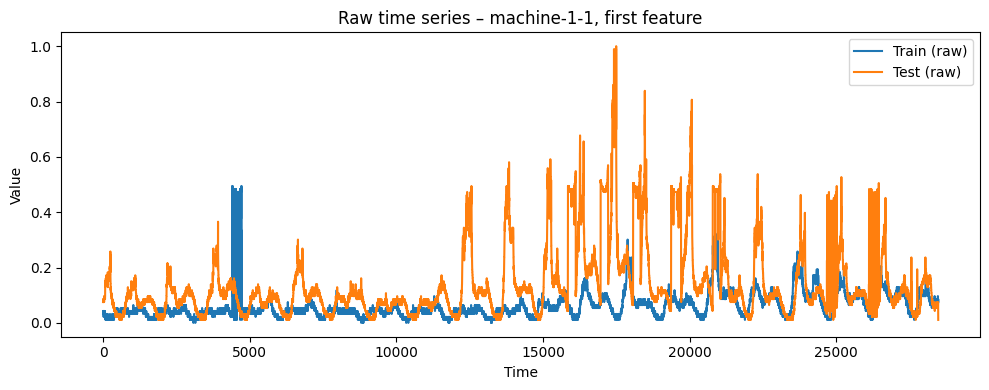

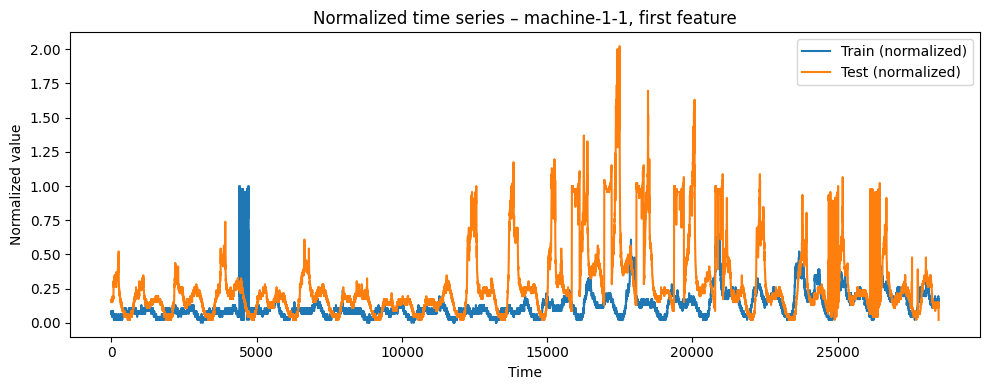

In [ ]:

# ==== 8.2 Load & Normalize Data ====

from pathlib import Path

# Use the SMD_TRAIN_DIR defined in the previous section, which correctly points to the 'train' subdirectory
train_data, test_data, test_labels = load_smd_machine(SMD_TRAIN_DIR, MACHINE_ID)

# Normalize using training statistics
train_norm, test_norm, data_min, data_max = min_max_normalize(train_data, test_data)

print("train_norm:", train_norm.shape)
print("test_norm :", test_norm.shape)

# Quick sanity check on first feature
plt.figure(figsize=(10, 4))
plt.plot(train_data[:, 0], label="Train (raw)")
plt.plot(test_data[:, 0], label="Test (raw)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Raw time series – {MACHINE_ID}, first feature")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_norm[:, 0], label="Train (normalized)")
plt.plot(test_norm[:, 0], label="Test (normalized)")
plt.xlabel("Time")
plt.ylabel("Normalized value")
plt.title(f"Normalized time series – {MACHINE_ID}, first feature")
plt.legend()
plt.tight_layout()
plt.show()


## 8.3 **Creating Sliding Windows**

In [ ]:

# ==== 8.3 Create Sliding Windows & DataLoaders ====

train_windows = create_sliding_windows(train_norm, WINDOW_SIZE)
test_windows = create_sliding_windows(test_norm, WINDOW_SIZE)

print("Train windows shape:", train_windows.shape)
print("Test  windows shape:", test_windows.shape)

train_loader, val_loader = create_dataloaders(
    train_windows, batch_size=BATCH_SIZE, val_ratio=0.2
)

input_dim = train_data.shape[1]
print("Input dimension (features):", input_dim)


Train windows shape: (28479, 10, 38)
Test  windows shape: (28479, 10, 38)
Input dimension (features): 38


## 8.4 **Mean Recunstruction Baseline**

In [ ]:

# ==== 8.4 Mean Reconstruction Baseline ====

print("\n=== Mean Reconstruction Baseline ===")
mean_model = MeanReconstructionBaseline()
_ = fit_model(mean_model, train_loader, val_loader, num_epochs=1)

train_errors_mean = compute_reconstruction_errors(mean_model, train_windows)
test_errors_mean = compute_reconstruction_errors(mean_model, test_windows)

# quick sanity check on error scale
test_scores = test_errors_mean # Corrected: use test_errors_mean for the Mean Baseline
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_mean = choose_threshold(train_errors_mean, quantile=0.995)
    y_pred_mean = compute_predictions(test_errors_mean, thr_mean)
    metrics_mean = evaluate_anomaly_detection(test_labels, test_errors_mean, y_pred_mean)
    print("Mean baseline metrics:", metrics_mean)
else:
    print("No labels available: skipping metric computation for baseline.")



=== Mean Reconstruction Baseline ===
Epoch 001 | train_loss=0.000665 | val_loss=0.000736
Huge values: 480
min / max: 9.320031e-16 73592075000000.0
Mean baseline metrics: {'precision': 0.5684257602862254, 'recall': 0.4717891610987379, 'f1': 0.5156186612576065, 'auc_roc': 0.9105172562963193, 'auc_pr': 0.5766780297535459}


## 8.5 **LSTM Autoecoder**

In [ ]:

# ==== 8.5 LSTM Autoencoder ====

print("\n=== LSTM Autoencoder ===")
lstm_model = LSTMAutoencoder(input_dim=input_dim, hidden_dim=64, latent_dim=32)
hist_lstm = fit_model(lstm_model, train_loader, val_loader, num_epochs=EPOCHS, lr=1e-3)

train_errors_lstm = compute_reconstruction_errors(lstm_model, train_windows)
test_errors_lstm = compute_reconstruction_errors(lstm_model, test_windows)

# quick sanity check on error scale
test_scores = test_errors_lstm # Corrected: use test_errors_lstm for the LSTM Autoencoder
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_lstm = choose_threshold(train_errors_lstm, quantile=0.995)
    y_pred_lstm = compute_predictions(test_errors_lstm, thr_lstm)
    metrics_lstm = evaluate_anomaly_detection(test_labels, test_errors_lstm, y_pred_lstm)
    print("LSTM metrics:", metrics_lstm)
else:
    print("No labels available: skipping metric computation for LSTM.")



=== LSTM Autoencoder ===
Epoch 001 | train_loss=0.010115 | val_loss=0.002465
Epoch 002 | train_loss=0.002010 | val_loss=0.001854
Epoch 003 | train_loss=0.001383 | val_loss=0.001613
Epoch 004 | train_loss=0.001245 | val_loss=0.001526
Epoch 005 | train_loss=0.001197 | val_loss=0.001517
Epoch 006 | train_loss=0.001151 | val_loss=0.001475
Epoch 007 | train_loss=0.001104 | val_loss=0.001432
Epoch 008 | train_loss=0.001068 | val_loss=0.001427
Epoch 009 | train_loss=0.001042 | val_loss=0.001344
Epoch 010 | train_loss=0.001026 | val_loss=0.001348
Epoch 011 | train_loss=0.001019 | val_loss=0.001402
Epoch 012 | train_loss=0.001005 | val_loss=0.001342
Epoch 013 | train_loss=0.001003 | val_loss=0.001374
Epoch 014 | train_loss=0.000993 | val_loss=0.001302
Epoch 015 | train_loss=0.000987 | val_loss=0.001334
Epoch 016 | train_loss=0.000981 | val_loss=0.001303
Epoch 017 | train_loss=0.000978 | val_loss=0.001287
Epoch 018 | train_loss=0.000973 | val_loss=0.001330
Epoch 019 | train_loss=0.000968 | val_

## 8.6 Testing **trasfromer with LayerNrom**

### Description of LSTM Model Metrics

The LSTM model's performance in anomaly detection is typically evaluated using several key metrics that assess its ability to correctly identify anomalous data points while minimizing false alarms. For this project, the following metrics are used:

-   **Precision**: Precision measures the proportion of correctly identified anomalous points among all points predicted as anomalous. A high precision indicates a low rate of false positives (i.e., normal points incorrectly flagged as anomalies). In anomaly detection, this is crucial when the cost of false alarms is high.

    $\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$

-   **Recall**: Recall (also known as Sensitivity) measures the proportion of correctly identified anomalous points among all actual anomalous points. A high recall indicates a low rate of false negatives (i.e., actual anomalies missed by the model). In anomaly detection, this is critical when the cost of missing an anomaly is high.

    $\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$

-   **F1-score**: The F1-score is the harmonic mean of Precision and Recall. It provides a single metric that balances both concerns. A high F1-score indicates that the model has good balance between precision and recall.

    $\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

-   **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)**: ROC-AUC evaluates the model's ability to distinguish between normal and anomalous classes across various threshold settings. An AUC-ROC score closer to 1.0 indicates a better ability to separate the classes. It's robust to imbalanced datasets.

-   **PR-AUC (Precision-Recall - Area Under the Curve)**: PR-AUC is particularly useful for highly imbalanced datasets, which are common in anomaly detection (where anomalies are rare). It focuses on the positive class (anomalies) and provides a more informative measure than ROC-AUC when the number of true negatives is overwhelmingly large. A higher PR-AUC indicates better performance for detecting the rare class.

These metrics collectively offer a comprehensive view of how well the LSTM autoencoder detects anomalies based on reconstruction errors.

### Explanation of `LSTMAutoencoder`

The `LSTMAutoencoder` is a neural network architecture built for sequence reconstruction, commonly used in anomaly detection. It consists of an encoder that compresses the input sequence into a lower-dimensional latent representation, and a decoder that reconstructs the original sequence from this latent representation.

#### `__init__(self, input_dim: int, hidden_dim: int = 64, latent_dim: int = 32, num_layers: int = 1)`

-   **`input_dim`**: This is the number of features (dimensions) in each time step of the input sequence. For the SMD dataset, this is 38.
-   **`hidden_dim`**: The number of hidden units in the LSTM layers. A larger value allows the LSTM to learn more complex patterns.
-   **`latent_dim`**: The dimension of the compressed representation generated by the encoder. This bottleneck forces the model to learn the most salient features of the input.
-   **`num_layers`**: The number of recurrent layers in both the encoder and decoder LSTMs. More layers can capture deeper temporal dependencies.

    -   **`self.encoder`**: An `nn.LSTM` layer that processes the input sequence. It takes `input_dim` as input features and outputs `hidden_dim` for each time step. `batch_first=True` means the input and output tensors will have `(batch_size, sequence_length, features)` dimensions.
    -   **`self.enc_to_latent`**: A linear layer (`nn.Linear`) that maps the last hidden state of the encoder (of size `hidden_dim`) to the `latent_dim` space. This is the bottleneck layer.
    -   **`self.latent_to_dec`**: A linear layer that maps the `latent_dim` representation back to `hidden_dim` to serve as the initial hidden state for the decoder.
    -   **`self.decoder`**: Another `nn.LSTM` layer. Its `input_dim` is `hidden_dim` because it receives a repeated version of the `latent_to_dec` output. It aims to output a sequence with `input_dim` features, reconstructing the original data.

#### `forward(self, x)`

This method defines how data flows through the autoencoder:

1.  **Encoder Pass**: `enc_out, _ = self.encoder(x)`
    -   The input `x` (shape `B, K, D`, where `B` is batch size, `K` is window size, `D` is `input_dim`) is fed into the `encoder` LSTM.
    -   `enc_out` contains the hidden states for each time step of the input sequence (shape `B, K, hidden_dim`).
    -   `h_last = enc_out[:, -1, :]` extracts the *last* hidden state from `enc_out`, which is considered the summary of the entire input sequence (shape `B, hidden_dim`).

2.  **Latent Representation**: `z = self.enc_to_latent(h_last)`
    -   The `h_last` (encoder's final hidden state) is passed through a linear layer to get the compressed latent representation `z` (shape `B, latent_dim`).

3.  **Decoder Input Preparation**:
    -   `dec_init = self.latent_to_dec(z).unsqueeze(1)` maps the latent representation `z` back to `hidden_dim` and adds a sequence dimension, making its shape `B, 1, hidden_dim`.
    -   `K = x.shape[1]` gets the original sequence length from the input.
    -   `dec_input = dec_init.repeat(1, K, 1)` repeats `dec_init` `K` times along the sequence dimension. This creates an input sequence for the decoder where each time step is the same (derived from the latent space), effectively forcing the decoder to reconstruct the original sequence based solely on this compressed information.

4.  **Decoder Pass**: `dec_out, _ = self.decoder(dec_input)`
    -   The `dec_input` (shape `B, K, hidden_dim`) is fed into the `decoder` LSTM.
    -   `dec_out` is the reconstructed sequence, matching the original input's shape `B, K, input_dim`.

In [ ]:

# ==== 8.6 Transformer Autoencoder ====

print("\n=== Transformer Autoencoder (with LayerNorm) ===")
transf_model = TransformerAELN(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf = fit_model(transf_model, train_loader, val_loader, num_epochs=EPOCHS, lr=1e-3)

train_errors_transf = compute_reconstruction_errors(transf_model, train_windows)
test_errors_transf  = compute_reconstruction_errors(transf_model,  test_windows)

# quick sanity check on error scale
test_scores = test_errors_transf
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_transf = choose_threshold(train_errors_transf, quantile=0.995)
    y_pred_transf = compute_predictions(test_errors_transf, thr_transf)
    metrics_transf = evaluate_anomaly_detection(test_labels, test_errors_transf, y_pred_transf)
    print("Transformer metrics:", metrics_transf)
else:
    print("No labels available: skipping metric computation for Transformer.")



=== Transformer Autoencoder (with LayerNorm) ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.481280 | val_loss=0.287922
Epoch 002 | train_loss=0.161426 | val_loss=0.056522
Epoch 003 | train_loss=0.021087 | val_loss=0.012739
Epoch 004 | train_loss=0.005142 | val_loss=0.009251
Epoch 005 | train_loss=0.004031 | val_loss=0.008212
Epoch 006 | train_loss=0.003674 | val_loss=0.007514
Epoch 007 | train_loss=0.003261 | val_loss=0.006923
Epoch 008 | train_loss=0.002903 | val_loss=0.006504
Epoch 009 | train_loss=0.002650 | val_loss=0.006131
Epoch 010 | train_loss=0.002459 | val_loss=0.005829
Epoch 011 | train_loss=0.002302 | val_loss=0.005619
Epoch 012 | train_loss=0.002151 | val_loss=0.005237
Epoch 013 | train_loss=0.001971 | val_loss=0.004784
Epoch 014 | train_loss=0.001652 | val_loss=0.003795
Epoch 015 | train_loss=0.001077 | val_loss=0.002417
Epoch 016 | train_loss=0.000850 | val_loss=0.001733
Epoch 017 | train_loss=0.000761 | val_loss=0.001396
Epoch 018 | train_loss=0.000686 | val_loss=0.001194
Epoch 019 | train_loss=0.000606 | val_loss=0.001015
Epoch 020 | 

### **Trasformer with more dropout** for 8.6.3

In [ ]:
class TransformerAELNDrop(nn.Module):
    """
    Transformer autoencoder with LayerNorm and higher dropout.
    """
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1, dropout=0.3):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, 10, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        x = self.input_proj(x) + self.pos_embedding
        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out


## 8.6.1 **Trasformer (LayerNorms) - 40 epochs**

In [ ]:
# ==== 8.6.1 Transformer (LayerNorm) – more epochs ====

EPOCHS_TRANSF_LONG = 40

transf_model_long = TransformerAELN(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf_long = fit_model(
    transf_model_long,
    train_loader,
    val_loader,
    num_epochs=EPOCHS_TRANSF_LONG,
    lr=1e-3
)

train_errors_transf_long = compute_reconstruction_errors(transf_model_long, train_windows)
test_errors_transf_long  = compute_reconstruction_errors(transf_model_long, test_windows)

# sanity check
print("[Transf-long] Huge values:", np.sum(test_errors_transf_long > 10))
print("[Transf-long] min / max:", test_errors_transf_long.min(), test_errors_transf_long.max())

if test_labels is not None:
    thr_transf_long    = choose_threshold(train_errors_transf_long, quantile=0.995)
    y_pred_transf_long = compute_predictions(test_errors_transf_long, thr_transf_long)
    metrics_transf_long = evaluate_anomaly_detection(test_labels, test_errors_transf_long, y_pred_transf_long)
    print("Transformer (40 epochs) metrics:", metrics_transf_long)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.483483 | val_loss=0.293753
Epoch 002 | train_loss=0.171739 | val_loss=0.074331
Epoch 003 | train_loss=0.026625 | val_loss=0.013490
Epoch 004 | train_loss=0.005319 | val_loss=0.009111
Epoch 005 | train_loss=0.004256 | val_loss=0.008280
Epoch 006 | train_loss=0.003984 | val_loss=0.007862
Epoch 007 | train_loss=0.003650 | val_loss=0.007327
Epoch 008 | train_loss=0.003340 | val_loss=0.007069
Epoch 009 | train_loss=0.003136 | val_loss=0.006817
Epoch 010 | train_loss=0.002992 | val_loss=0.006576
Epoch 011 | train_loss=0.002883 | val_loss=0.006358
Epoch 012 | train_loss=0.002787 | val_loss=0.006047
Epoch 013 | train_loss=0.002696 | val_loss=0.005849
Epoch 014 | train_loss=0.002603 | val_loss=0.005629
Epoch 015 | train_loss=0.002500 | val_loss=0.005325
Epoch 016 | train_loss=0.002375 | val_loss=0.004958
Epoch 017 | train_loss=0.002196 | val_loss=0.004335
Epoch 018 | train_loss=0.001630 | val_loss=0.001719
Epoch 019 | train_loss=0.000681 | val_loss=0.000975
Epoch 020 | 

In [ ]:
print("hist_lstm  in globals?  ", 'hist_lstm' in globals())
print("hist_transf in globals? ", 'hist_transf' in globals())
print("lstm_model in globals? ", 'lstm_model' in globals())
print("transf_model in globals?", 'transf_model' in globals())


## 8.6.2 **Trasformer + Huber loss**

In [ ]:

transf_model_huber = TransformerAELN(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf_huber = fit_model_huber(
    transf_model_huber,
    train_loader,
    val_loader,
    num_epochs=EPOCHS,   # es. 20
    lr=1e-3
)

train_errors_transf_huber = compute_reconstruction_errors(transf_model_huber, train_windows)
test_errors_transf_huber  = compute_reconstruction_errors(transf_model_huber,  test_windows)

print("[Transf-huber] Huge values:", np.sum(test_errors_transf_huber > 10))
print("[Transf-huber] min / max:", test_errors_transf_huber.min(), test_errors_transf_huber.max())

if test_labels is not None:
    thr_transf_huber    = choose_threshold(train_errors_transf_huber, quantile=0.995)
    y_pred_transf_huber = compute_predictions(test_errors_transf_huber, thr_transf_huber)
    metrics_transf_huber = evaluate_anomaly_detection(test_labels, test_errors_transf_huber, y_pred_transf_huber)
    print("Transformer (Huber) metrics:", metrics_transf_huber)


## 8.6.3 **Transformer Autoencoder with extra dropout**

In [ ]:

# ==== 8.6.3 Transformer Autoencoder with more dropout ====

print("\n=== Transformer Autoencoder (with LayerNorm & higher dropout) ===")
transf_model_drop = TransformerAELNDrop(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf_drop = fit_model(
    transf_model_drop,
    train_loader,
    val_loader,
    num_epochs=EPOCHS,
    lr=1e-3
)

train_errors_transf_drop = compute_reconstruction_errors(transf_model_drop, train_windows)
test_errors_transf_drop  = compute_reconstruction_errors(transf_model_drop, test_windows)

# sanity check
test_scores = test_errors_transf_drop
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_transf_drop = choose_threshold(train_errors_transf_drop, quantile=0.995)
    y_pred_transf_drop = compute_predictions(test_errors_transf_drop, thr_transf_drop)
    metrics_transf_drop = evaluate_anomaly_detection(test_labels, test_errors_transf_drop, y_pred_transf_drop)
    print("Transformer (Dropout) metrics:", metrics_transf_drop)
else:
    print("No labels available: skipping metric computation for Transformer.")


## 8.6.4 **Transformer Autoencoder (LayerNorm + mixed positional encoding)**

In [ ]:

print("\n=== Transformer Autoencoder (LayerNorm + mixed positional encoding) ===")
transf_model_mixed = TransformerAEMixedPos(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    max_len=WINDOW_SIZE # Corrected: Changed 'K' to 'max_len'
)

hist_transf_mixed = fit_model(
    transf_model_mixed,
    train_loader,
    val_loader,
    num_epochs=EPOCHS,
    lr=1e-3
)

train_errors_transf_mixed = compute_reconstruction_errors(transf_model_mixed, train_windows)
test_errors_transf_mixed  = compute_reconstruction_errors(transf_model_mixed,  test_windows)

test_scores = test_errors_transf_mixed
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_transf_mixed = choose_threshold(train_errors_transf_mixed, quantile=0.995)
    y_pred_transf_mixed = compute_predictions(test_errors_transf_mixed, thr_transf_mixed)
    metrics_transf_mixed = evaluate_anomaly_detection(test_labels, test_errors_transf_mixed, y_pred_transf_mixed)
    print("Transformer (MixedPos) metrics:", metrics_transf_mixed)
else:
    print("No labels available: skipping metric computation for Transformer (MixedPos).")

In [ ]:
# ==== Select best Transformer variant for downstream analyses ====

best_transf_model   = transf_model_long         # long
best_hist_transf    = hist_transf_long
best_train_errors   = train_errors_transf_long
best_test_errors    = test_errors_transf_long

# per compatibilità con il resto del notebook:
transf_model        = best_transf_model
hist_transf         = best_hist_transf
train_errors_transf = best_train_errors
test_errors_transf  = best_test_errors


## 8.7 - 8.13  Example: **feature-level diagnosis** with the Transformer model

Below we illustrate how to:

1. Compute feature-wise errors for the Transformer autoencoder.
2. Learn per-feature thresholds from the training windows.
3. Obtain a `(T, D)` binary matrix of anomalous dimensions.
4. Inspect, for a few anomalous timestamps, which features are flagged as anomalous.


8.7 **Loss curves LSTM vs Trasformers**

In [ ]:

# ==== 8.7 Loss Curves for LSTM vs Transformer ====

if 'hist_lstm' in globals() and 'hist_transf' in globals():
    plt.figure(figsize=(8,4))
    plt.plot(hist_lstm["train_loss"],   label="LSTM train")
    plt.plot(hist_lstm["val_loss"],     label="LSTM val")
    plt.plot(hist_transf["train_loss"], label="Transformer train")
    plt.plot(hist_transf["val_loss"],   label="Transformer val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Training and validation loss – machine-1-1")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:

# ==== 8.8 Feature-level diagnosis with Transformer Autoencoder ====

if 'transf_model' in globals():
    print("\n=== Feature-level diagnosis (Transformer) ===")
    # 1. Compute feature-wise errors on train and test
    feat_errors_train_transf = compute_feature_level_errors(transf_model, train_windows)
    feat_errors_test_transf = compute_feature_level_errors(transf_model, test_windows)

    print("Feature-level error matrices:")
    print("  train:", feat_errors_train_transf.shape)
    print("  test :", feat_errors_test_transf.shape)

    # 2. Learn per-feature thresholds from training errors
    feat_thresholds_transf = choose_feature_thresholds(feat_errors_train_transf, quantile=0.995)

    # 3. Multi-label predictions per (time, feature)
    y_pred_feat_transf = compute_feature_level_predictions(feat_errors_test_transf, feat_thresholds_transf)
    print("Feature-level prediction matrix shape:", y_pred_feat_transf.shape)

    # 4. Inspect a few anomalous timestamps according to time-level Transformer detection
    if 'y_pred_transf' in globals():
        anomalous_times = np.where(y_pred_transf == 1)[0]
        print(f"Number of anomalous timestamps (time-level): {len(anomalous_times)}")

        for t in anomalous_times[:5]:  # show up to 5
            anomalous_features = np.where(y_pred_feat_transf[t] == 1)[0]
            print(f"t = {t:5d} | anomalous features (indices) = {anomalous_features}")
    else:
        print("Warning: 'y_pred_transf' not found – run the Transformer time-level detection first.")
else:
    print("Warning: 'transf_model' not found – train the Transformer model first.")


8.9 **Error scale and outlier filtering (Transformer)**: The goal of this analysis is to visualise how much the reconstruction error distributions for normal and anomalous timestamps overlap, and to qualitatively compare this behaviour with the narrative in the reference paper.

In [ ]:
# ==== 8.9 Error scale and outlier filtering (Transformer) ====

train_scores = np.asarray(train_errors_transf)
test_scores  = np.asarray(test_errors_transf)

print("Train scores shape:", train_scores.shape)
print("Test  scores shape:", test_scores.shape)
print("Train scores  min / max:", float(train_scores.min()), float(train_scores.max()))
print("Test  scores  min / max:", float(test_scores.min()),  float(test_scores.max()))

# Check and filter extreme values
test_scores = np.asarray(test_errors_transf)
mask_good = np.isfinite(test_scores) & (test_scores < 1e3)

print("Original test scores:", test_scores.shape)
print("Non-finite values:", np.sum(~np.isfinite(test_scores)))
print("Extremely large values:", np.sum(test_scores >= 1e3))

test_scores_filtered = test_scores[mask_good]
print("Filtered test scores:", test_scores_filtered.shape)
print("Filtered min/max:", test_scores_filtered.min(), test_scores_filtered.max())


8.10 **Error distribution (normal vs anomaly)**:The goal of this analysis is to visualise how much the reconstruction error distributions for normal and anomalous timestamps overlap, and to qualitatively compare this behaviour with the narrative in the reference paper.

In [ ]:
# ==== 8.10 Error distribution: normal vs anomaly ====

import numpy as np
import matplotlib.pyplot as plt

test_scores = np.asarray(test_errors_transf)

# stesso filtro che hai già usato
mask_good = np.isfinite(test_scores) & (test_scores < 1e3)
scores_good   = test_scores[mask_good]
labels_good   = test_labels[mask_good]

normal_scores  = scores_good[labels_good == 0]
anomaly_scores = scores_good[labels_good == 1]

plt.figure(figsize=(8,4))
plt.hist(normal_scores,  bins=50, density=True, alpha=0.6, label="Normal")
plt.hist(anomaly_scores, bins=50, density=True, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.title("Error distribution – Transformer autoencoder (filtered)")
plt.legend()
plt.show()



8.11 **Score vs ground truth (zoomed interval)**

In [ ]:
np.where(test_labels[3000:3800] == 1)[0]
# indici di tutti i timestamp anomali nel test set
anom_idx = np.where(test_labels == 1)[0]
anom_idx.min(), anom_idx.max()


In [ ]:
center = anom_idx[0]        # o anom_idx[100], ecc.
half_window = 200

t0 = max(0, center - half_window)
t1 = min(len(test_labels), center + half_window)

print(t0, t1)


In [ ]:
plt.figure(figsize=(10, 5))

# 1) raw feature
plt.plot(test_data[t0:t1, 0], label='Feature 0 (raw)', alpha=0.7)
plt.ylabel("Value")

# 2) reconstruction error on second y-axis
plt.twinx()
test_scores = test_errors_transf
plt.plot(test_scores[t0:t1], label='Reconstruction error', alpha=0.7, color='green')
plt.ylabel("Error")

# 3) anomalies
anomalous_idx = np.where(test_labels[t0:t1] == 1)[0]
plt.scatter(anomalous_idx,
            test_scores[t0:t1][anomalous_idx],
            marker='x',
            label='Anomaly',
            color='red')

plt.title("Raw signal and reconstruction error (zoomed interval)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

8.12 **Feature-wise error heatmap**: The objective is to approximate the “attention heatmaps” shown in the reference paper by visualising feature-wise reconstruction errors over time. Instead of attention weights, we use the MSE per feature to identify which dimensions are most affected during anomaly intervals.

In [ ]:
# ==== 8.12 Feature-wise reconstruction error heatmap (Transformer) ====

window = slice(900, 1100)   # interval containing an anomaly
subset = feat_errors_test_transf[window, :].T  # (D, time)

plt.figure(figsize=(10, 6))
plt.imshow(subset, aspect='auto', origin='lower')
plt.colorbar(label='MSE per feature')
plt.xlabel("Time index (zoomed)")
plt.ylabel("Feature index")
plt.title("Feature-wise reconstruction error heatmap (Transformer)")
plt.tight_layout()
plt.show()


8.13 **Threshold sensitivity analysis**: The goal is to study how detection performance changes when varying the anomaly threshold, by sweeping different quantiles of the training error distribution (0.99, 0.995, 0.999). This analysis clarifies that our default threshold is intentionally tuned towards high recall and shows how more sophisticated models (such as TranAD) may exploit richer thresholding strategies.

# 9. **Further Improvements & Ablation Studies**

### 9.1 **Ablation: Window Size (K = 10, 30, 50)**

In [ ]:
# ==== 9.1 Window-size ablation: K = 10, 30, 50 ====

import numpy as np
import pandas as pd
import torch.nn as nn # Added import
import torch # Added import

# Redefine TransformerAELN to accept max_len for positional embedding
class TransformerAELN_Ablation(nn.Module):
    def __init__(self, input_dim: int, d_model: int = 64, nhead: int = 4, num_layers: int = 1, max_len: int = 10):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model)) # Use max_len here

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        B, K, D = x.shape
        # Ensure positional embedding is sliced to match current sequence length K
        x = self.input_proj(x) + self.pos_embedding[:, :K, :]

        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out

WINDOW_SIZES = [10, 30, 50]
EPOCHS_LSTM_ABL = 15     # you can increase if you have time (20–30)
EPOCHS_TRANSF_ABL = 20   # same

results_ws = []

for K in WINDOW_SIZES:
    print(f"\n\n=== Window size K = {K} ===")

    # 1) Reload and normalise data for the current machine
    train_data, test_data, test_labels = load_smd_machine(SMD_TRAIN_DIR, MACHINE_ID)
    train_norm, test_norm, data_min, data_max = min_max_normalize(train_data, test_data)

    # 2) Create sliding windows
    train_windows = create_sliding_windows(train_norm, K)
    test_windows  = create_sliding_windows(test_norm,  K)

    print("Train windows:", train_windows.shape, "Test windows:", test_windows.shape)

    # 3) Dataloaders
    train_loader, val_loader = create_dataloaders(
        train_windows, batch_size=BATCH_SIZE, val_ratio=0.2
    )

    input_dim = train_data.shape[1]

    # ------------ LSTM ------------
    print("\n[LSTM] Training...")
    lstm_model = LSTMAutoencoder(input_dim=input_dim, hidden_dim=64, latent_dim=32)
    _ = fit_model(lstm_model, train_loader, val_loader, num_epochs=EPOCHS_LSTM_ABL, lr=1e-3)

    train_errors_lstm = compute_reconstruction_errors(lstm_model, train_windows)
    test_errors_lstm  = compute_reconstruction_errors(lstm_model,  test_windows)

    thr_lstm = choose_threshold(train_errors_lstm, quantile=0.995)
    y_pred_lstm = compute_predictions(test_errors_lstm, thr_lstm)
    metrics_lstm = evaluate_anomaly_detection(test_labels, test_errors_lstm, y_pred_lstm)

    # ------------ Transformer (LayerNorm) ------------
    print("\n[Transformer LN] Training...")
    transf_model = TransformerAELN_Ablation( # Use the modified class here
        input_dim=input_dim,
        d_model=64,
        nhead=4,
        num_layers=1,
        max_len=K # Pass K as max_len
    )
    _ = fit_model(transf_model, train_loader, val_loader, num_epochs=EPOCHS_TRANSF_ABL, lr=1e-3)

    train_errors_transf = compute_reconstruction_errors(transf_model, train_windows)
    test_errors_transf  = compute_reconstruction_errors(transf_model,  test_windows)

    thr_transf = choose_threshold(train_errors_transf, quantile=0.995)
    y_pred_transf = compute_predictions(test_errors_transf, thr_transf)
    metrics_transf = evaluate_anomaly_detection(test_labels, test_errors_transf, y_pred_transf)

    # 4) Save results
    results_ws.append({
        "K": K,
        "model": "LSTM AE",
        **metrics_lstm
    })
    results_ws.append({
        "K": K,
        "model": "Transformer AE (LN)",
        **metrics_transf
    })

# 5) Summary table
df_ws = pd.DataFrame(results_ws)
print("\n=== Window-size ablation summary ===")
display(df_ws)



=== Window size K = 10 ===
Loaded SMD machine machine-1-1
Train shape: (28479, 38)
Test  shape: (28479, 38)
Labels shape: (28479,)
Number of anomalous points in test: 2694
Train windows: (28479, 10, 38) Test windows: (28479, 10, 38)

[LSTM] Training...
Epoch 001 | train_loss=0.010119 | val_loss=0.002549
Epoch 002 | train_loss=0.002297 | val_loss=0.002155
Epoch 003 | train_loss=0.001545 | val_loss=0.001722
Epoch 004 | train_loss=0.001311 | val_loss=0.001601
Epoch 005 | train_loss=0.001224 | val_loss=0.001513
Epoch 006 | train_loss=0.001166 | val_loss=0.001458
Epoch 007 | train_loss=0.001112 | val_loss=0.001378
Epoch 008 | train_loss=0.001083 | val_loss=0.001384
Epoch 009 | train_loss=0.001063 | val_loss=0.001398
Epoch 010 | train_loss=0.001048 | val_loss=0.001379
Epoch 011 | train_loss=0.001037 | val_loss=0.001395
Epoch 012 | train_loss=0.001027 | val_loss=0.001326
Epoch 013 | train_loss=0.001015 | val_loss=0.001269
Epoch 014 | train_loss=0.001002 | val_loss=0.001296
Epoch 015 | train

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.481059 | val_loss=0.287677
Epoch 002 | train_loss=0.160534 | val_loss=0.063512
Epoch 003 | train_loss=0.024855 | val_loss=0.013969
Epoch 004 | train_loss=0.005739 | val_loss=0.008607
Epoch 005 | train_loss=0.004173 | val_loss=0.007774
Epoch 006 | train_loss=0.003829 | val_loss=0.007285
Epoch 007 | train_loss=0.003504 | val_loss=0.006855
Epoch 008 | train_loss=0.003225 | val_loss=0.006530
Epoch 009 | train_loss=0.003005 | val_loss=0.006151
Epoch 010 | train_loss=0.002812 | val_loss=0.005846
Epoch 011 | train_loss=0.002648 | val_loss=0.005440
Epoch 012 | train_loss=0.002494 | val_loss=0.005097
Epoch 013 | train_loss=0.002329 | val_loss=0.004735
Epoch 014 | train_loss=0.002113 | val_loss=0.004127
Epoch 015 | train_loss=0.001683 | val_loss=0.002698
Epoch 016 | train_loss=0.001007 | val_loss=0.001681
Epoch 017 | train_loss=0.000849 | val_loss=0.001393
Epoch 018 | train_loss=0.000808 | val_loss=0.001290
Epoch 019 | train_loss=0.000783 | val_loss=0.001237
Epoch 020 | 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.482440 | val_loss=0.291323
Epoch 002 | train_loss=0.169602 | val_loss=0.069283
Epoch 003 | train_loss=0.025535 | val_loss=0.014697
Epoch 004 | train_loss=0.005947 | val_loss=0.010035
Epoch 005 | train_loss=0.004788 | val_loss=0.008932
Epoch 006 | train_loss=0.004400 | val_loss=0.008340
Epoch 007 | train_loss=0.004060 | val_loss=0.007947
Epoch 008 | train_loss=0.003780 | val_loss=0.007445
Epoch 009 | train_loss=0.003433 | val_loss=0.006991
Epoch 010 | train_loss=0.003127 | val_loss=0.006432
Epoch 011 | train_loss=0.002806 | val_loss=0.005282
Epoch 012 | train_loss=0.002358 | val_loss=0.004199
Epoch 013 | train_loss=0.001855 | val_loss=0.003017
Epoch 014 | train_loss=0.001090 | val_loss=0.001828
Epoch 015 | train_loss=0.000849 | val_loss=0.001414
Epoch 016 | train_loss=0.000789 | val_loss=0.001251
Epoch 017 | train_loss=0.000761 | val_loss=0.001180
Epoch 018 | train_loss=0.000741 | val_loss=0.001136
Epoch 019 | train_loss=0.000724 | val_loss=0.001121
Epoch 020 | 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.479285 | val_loss=0.285793
Epoch 002 | train_loss=0.163313 | val_loss=0.065832
Epoch 003 | train_loss=0.026332 | val_loss=0.015102
Epoch 004 | train_loss=0.006196 | val_loss=0.011178
Epoch 005 | train_loss=0.005204 | val_loss=0.010097
Epoch 006 | train_loss=0.004898 | val_loss=0.009751
Epoch 007 | train_loss=0.004600 | val_loss=0.009225
Epoch 008 | train_loss=0.004357 | val_loss=0.008969
Epoch 009 | train_loss=0.004138 | val_loss=0.008596
Epoch 010 | train_loss=0.003837 | val_loss=0.008172
Epoch 011 | train_loss=0.003527 | val_loss=0.007761
Epoch 012 | train_loss=0.003275 | val_loss=0.007374
Epoch 013 | train_loss=0.003067 | val_loss=0.007061
Epoch 014 | train_loss=0.002899 | val_loss=0.006657
Epoch 015 | train_loss=0.002694 | val_loss=0.006001
Epoch 016 | train_loss=0.002358 | val_loss=0.005118
Epoch 017 | train_loss=0.001504 | val_loss=0.002586
Epoch 018 | train_loss=0.000965 | val_loss=0.001723
Epoch 019 | train_loss=0.000756 | val_loss=0.001074
Epoch 020 | 

,K,model,precision,recall,f1,auc_roc,auc_pr
0,10,LSTM AE,0.205842,0.952116,0.338502,0.876453,0.493460
1,10,Transformer AE (LN),0.351630,0.456570,0.397287,0.867552,0.439470
2,30,LSTM AE,0.184695,0.994432,0.311530,0.888237,0.484655
3,30,Transformer AE (LN),0.360836,0.500000,0.419169,0.889713,0.440073
4,50,LSTM AE,0.218512,0.956941,0.355783,0.895340,0.463093
5,50,Transformer AE (LN),0.343051,0.506682,0.409111,0.893606,0.410073


### 9.2 **Transformer (LayerNorm + Dropout + Huber Loss)**

This section evaluates the Transformer model with Layer Normalization, increased dropout, and trained using the Huber loss (SmoothL1Loss) for improved robustness. This combination aims to enhance stability and performance, especially in the presence of outliers in the error distribution.

In [ ]:
# ==== 9.2.1 TransformerAELNDrop: LN + higher dropout ====

import torch
import torch.nn as nn

class TransformerAELNDrop(nn.Module):
    """
    Transformer autoencoder with LayerNorm, higher dropout and learned positional embeddings.
    """
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1, max_len=512, dropout=0.3):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: (B, K, D)
        B, K, D = x.shape
        pos_ids = torch.arange(0, K, device=x.device).unsqueeze(0).repeat(B, 1)
        x = self.input_proj(x) + self.pos_embedding(pos_ids)
        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out

In [ ]:
# ==== 9.2.2 Transformer (LN + Dropout + Huber loss) ====

import torch.nn as nn
import numpy as np

def fit_model_huber(
    model: nn.Module,
    train_loader,
    val_loader,
    num_epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-5,
    delta: float = 1.0
):
    """
    Training loop with Huber (SmoothL1) loss.
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss(beta=delta)  # Huber-style loss

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        # --- train ---
        model.train()
        total_train, n_train = 0.0, 0
        for batch in train_loader:
            x = batch.to(device).float()
            recon = model(x)
            loss = criterion(recon, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train += loss.item() * x.size(0)
            n_train += x.size(0)
        train_loss = total_train / n_train

        # --- val ---
        model.eval()
        total_val, n_val = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch.to(device).float()
                recon = model(x)
                loss = criterion(recon, x)
                total_val += loss.item() * x.size(0)
                n_val += x.size(0)
        val_loss = total_val / n_val

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        print(f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

    return history

# ---- Run Huber Transformer on current machine and window size ----

print("\n=== 9.2 Transformer (LN + Dropout + Huber loss) ===")

# Usa gli stessi train_windows / test_windows / train_loader / val_loader già costruiti
# (per esempio con K=10 oppure K=30 se hai già fatto l'ablation)

transf_huber = TransformerAELNDrop(input_dim=input_dim, d_model=64, nhead=4, num_layers=1, dropout=0.3)
hist_transf_huber = fit_model_huber(
    transf_huber,
    train_loader,
    val_loader,
    num_epochs=20,
    lr=1e-3,
    delta=1.0
)

train_errors_huber = compute_reconstruction_errors(transf_huber, train_windows)
test_errors_huber  = compute_reconstruction_errors(transf_huber,  test_windows)

# soglia + metriche
thr_huber = choose_threshold(train_errors_huber, quantile=0.995)
y_pred_huber = compute_predictions(test_errors_huber, thr_huber)
metrics_huber = evaluate_anomaly_detection(test_labels, test_errors_huber, y_pred_huber)

print("\n[Transformer Huber] metrics:", metrics_huber)


=== 9.2 Transformer (LN + Dropout + Huber loss) ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.162933 | val_loss=0.111191
Epoch 002 | train_loss=0.082423 | val_loss=0.058856
Epoch 003 | train_loss=0.041852 | val_loss=0.020352
Epoch 004 | train_loss=0.010813 | val_loss=0.005098
Epoch 005 | train_loss=0.002910 | val_loss=0.004786
Epoch 006 | train_loss=0.002578 | val_loss=0.004512
Epoch 007 | train_loss=0.002354 | val_loss=0.004229
Epoch 008 | train_loss=0.002108 | val_loss=0.003953
Epoch 009 | train_loss=0.001890 | val_loss=0.003600
Epoch 010 | train_loss=0.001642 | val_loss=0.003257
Epoch 011 | train_loss=0.001415 | val_loss=0.002935
Epoch 012 | train_loss=0.001245 | val_loss=0.002588
Epoch 013 | train_loss=0.001095 | val_loss=0.002312
Epoch 014 | train_loss=0.000939 | val_loss=0.001923
Epoch 015 | train_loss=0.000691 | val_loss=0.001116
Epoch 016 | train_loss=0.000325 | val_loss=0.000538
Epoch 017 | train_loss=0.000252 | val_loss=0.000415
Epoch 018 | train_loss=0.000222 | val_loss=0.000365
Epoch 019 | train_loss=0.000199 | val_loss=0.000309
Epoch 020 | 

### 9.3 **Multi-Machine Evaluation (3-4 Machines)**

In [ ]:
# ==== 9.3 Multi-machine evaluation (3–4 machines) ====

import numpy as np
import pandas as pd

MACHINES = [
    "machine-1-1",
    "machine-1-2",
    "machine-1-3",
    "machine-2-1"
]

K_MULTI = 10          # you can also use 30 if you've already seen that it works better
EPOCHS_MULTI = 20
BATCH_SIZE = 128

multi_results = []

for mid in MACHINES:
    print(f"\n\n===== Machine: {mid} ====")

    # 1) Load + normalise
    train_data, test_data, test_labels = load_smd_machine(SMD_TRAIN_DIR, mid)
    train_norm, test_norm, data_min, data_max = min_max_normalize(train_data, test_data)

    # 2) Windows
    train_windows = create_sliding_windows(train_norm, K_MULTI)
    test_windows  = create_sliding_windows(test_norm,  K_MULTI)
    print("Train windows:", train_windows.shape, "Test windows:", test_windows.shape)

    # 3) Dataloaders
    train_loader, val_loader = create_dataloaders(
        train_windows, batch_size=BATCH_SIZE, val_ratio=0.2
    )
    input_dim = train_data.shape[1]

    # 4) Train best Transformer variant (LN, 40 epochs or 20 to save time)
    transf_model = TransformerAELN(
        input_dim=input_dim,
        d_model=64,
        nhead=4,
        num_layers=1
    )
    _ = fit_model(transf_model, train_loader, val_loader, num_epochs=EPOCHS_MULTI, lr=1e-3)

    train_errors_transf = compute_reconstruction_errors(transf_model, train_windows)
    test_errors_transf  = compute_reconstruction_errors(transf_model,  test_windows)

    thr_transf = choose_threshold(train_errors_transf, quantile=0.995)
    y_pred_transf = compute_predictions(test_errors_transf, thr_transf)
    metrics_transf = evaluate_anomaly_detection(test_labels, test_errors_transf, y_pred_transf)

    print(f"[{mid}] Transformer metrics:", metrics_transf)

    row = {"machine": mid, **metrics_transf}
    multi_results.append(row)

# Summary table across machines
df_multi = pd.DataFrame(multi_results)
print("\n=== Multi-machine summary (Transformer) ===")
display(df_multi)

print("\n=== Average metrics across machines ===")
print(df_multi.mean(numeric_only=True))

### 9.4 **Threshold Smoothing: Moving Average + Std-Boost**

In [ ]:
# ==== 9.4 Threshold smoothing: moving average + std-boost ====

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Assumiamo che train_errors_transf_long e test_errors_transf_long
# siano gli errori del "miglior" Transformer (LN, 40 epochs, K scelto)
train_scores = np.asarray(train_errors_transf_long)
test_scores  = np.asarray(test_errors_transf_long)

print("Train scores:", train_scores.shape, "Test scores:", test_scores.shape)

# Fix: Reload test_labels for the specific machine that test_errors_transf_long corresponds to (machine-1-1)
_, _, y_true_fixed = load_smd_machine(SMD_TRAIN_DIR, MACHINE_ID)
# Ensure y_true_fixed is not None, otherwise default to existing test_labels if no label file
if y_true_fixed is not None:
    y_true = y_true_fixed
else:
    y_true = test_labels # Fallback to the last loaded test_labels, though this might still be incorrect if MACHINE_ID labels are missing.


# 1) Moving average smoothing on test scores
def moving_average(x, window=5):
    if window <= 1:
        return x
    kernel = np.ones(window) / window
    y = np.convolve(x, kernel, mode="same")
    return y

WINDOW_SMOOTH = 5
test_scores_smooth = moving_average(test_scores, window=WINDOW_SMOOTH)

# 2) Threshold strategies
# 2.a) Quantile-based (baseline)
q = 0.995
thr_quant = np.quantile(train_scores, q)

# 2.b) Mean + lambda * std (std-boost) on training scores
mu = train_scores.mean()
sigma = train_scores.std()
LAMBDA = 3.0   # 3 std above mean
thr_std = mu + LAMBDA * sigma

print(f"Quantile thr (q={q}): {thr_quant:.4f}")
print(f"Std-boost thr (mu + {LAMBDA}*sigma): {thr_std:.4f}")

# 3) Predictions
# y_true = test_labels  # Original line: this was causing the mismatch

# Without smoothing
y_pred_quant_raw = (test_scores >= thr_quant).astype(int)
y_pred_std_raw   = (test_scores >= thr_std).astype(int)

# With smoothing
y_pred_quant_smooth = (test_scores_smooth >= thr_quant).astype(int)
y_pred_std_smooth   = (test_scores_smooth >= thr_std).astype(int)

def compute_basic_metrics(y_true, y_pred):
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f = f1_score(y_true, y_pred, zero_division=0)
    return p, r, f

print("\n=== Threshold comparison (no smoothing) ===")
print("Quantile (raw):   P,R,F1 =", compute_basic_metrics(y_true, y_pred_quant_raw))
print("Std-boost (raw):  P,R,F1 =", compute_basic_metrics(y_true, y_pred_std_raw))

print("\n=== Threshold comparison (with smoothing, MA window=5) ===")
print("Quantile (smooth): P,R,F1 =", compute_basic_metrics(y_true, y_pred_quant_smooth))
print("Std-boost (smooth):P,R,F1 =", compute_basic_metrics(y_true, y_pred_std_smooth))

#  9.5 **TransformerAELNDrop: LN + higher dropout + Sigmoid**

In [ ]:
# ==== 9.5 TransformerAELNDrop: LN + higher dropout + Sigmoid ====

import torch
import torch.nn as nn

class TransformerAELNDrop(nn.Module):
    """
    Transformer autoencoder with LayerNorm, higher dropout and learned positional embeddings.
    Output bounded in [0,1] via Sigmoid.
    """
    def __init__(
        self,
        input_dim: int = 38,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 1,
        max_len: int = 512,
        dropout: float = 0.3
    ):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        # Proiezione input + posizioni
        self.input_proj    = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output: un solo Linear + Sigmoid
        self.output_layer      = nn.Linear(d_model, input_dim)
        self.output_activation = nn.Sigmoid()  # vincola a [0,1]

    def forward(self, x):
        # x: (B, K, D)
        B, K, D = x.shape

        # Positional IDs
        pos_ids = torch.arange(0, K, device=x.device).unsqueeze(0).repeat(B, 1)

        # Input embedding + pos embedding
        x_emb = self.input_proj(x) + self.pos_embedding(pos_ids)

        # Encoder → latent z
        z = self.encoder(x_emb)

        # Decoder (usa le stesse posizioni come tgt)
        dec = self.decoder(tgt=x_emb, memory=z)

        # Output proiettato nello spazio input + Sigmoid
        out = self.output_layer(dec)
        out = self.output_activation(out)

        return out


# 9.6 **Transformer (LN + Dropout + Huber + Sigmoid + Clipping)**

In [ ]:
import torch
import torch.nn as nn
import numpy as np

def fit_model_huber(
    model: nn.Module,
    train_loader,
    val_loader,
    num_epochs: int = 20,
    lr: float = 5e-4,
    weight_decay: float = 1e-5,
    delta: float = 1.0,
    max_grad_norm: float = 1.0
):
    """
    Training loop with Huber (SmoothL1) loss + gradient clipping.
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss(beta=delta)  # Huber-style loss

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        # --- train ---
        model.train()
        total_train, n_train = 0.0, 0

        for batch in train_loader:
            x = batch.to(device).float()
            recon = model(x)
            loss = criterion(recon, x)

            optimizer.zero_grad()
            loss.backward()

            # 🔹 Gradient clipping qui
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

            optimizer.step()

            total_train += loss.item() * x.size(0)
            n_train += x.size(0)

        train_loss = total_train / n_train

        # --- val ---
        model.eval()
        total_val, n_val = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch.to(device).float()
                recon = model(x)
                loss = criterion(recon, x)
                total_val += loss.item() * x.size(0)
                n_val += x.size(0)
        val_loss = total_val / n_val

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        print(f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

    return history


In [ ]:
print("\n=== Transformer (LN + Dropout + Huber + Sigmoid + Clipping) ===")

best_model = TransformerAELNDrop(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.3
)

hist_best = fit_model_huber(
    best_model,
    train_loader,
    val_loader,
    num_epochs=20,
    lr=5e-4,
    delta=1.0,
    max_grad_norm=1.0
)

train_errors_best = compute_reconstruction_errors(best_model, train_windows)
test_errors_best  = compute_reconstruction_errors(best_model,  test_windows)

thr_best = choose_threshold(train_errors_best, quantile=0.995)
y_pred_best = compute_predictions(test_errors_best, thr_best)
metrics_best = evaluate_anomaly_detection(test_labels, test_errors_best, y_pred_best)

print("\n[Best Transformer Stabilized] metrics:", metrics_best)


# 9.7 Segments cleaning and processing

In [ ]:
import numpy as np


def clean_segments(preds: np.ndarray, min_len: int = 3) -> np.ndarray:
    """
    Removes anomalous segments that are too short.
    preds: binary array (T,)
    min_len: minimum length of a contiguous segment of 1s to keep.
    """
    preds = preds.copy()
    T = len(preds)
    start = None

    for t in range(T):
        if preds[t] == 1 and start is None:
            start = t
        # end of segment if we return to 0 or we are at the last index
        if (preds[t] == 0 or t == T - 1) and start is not None:
            end = t if preds[t] == 0 else t + 1  # end is exclusive
            if end - start < min_len:
                preds[start:end] = 0
            start = None

    return preds

In [ ]:
# --- Segment post-processing to increase precision ---
min_segment_len = 3  # you can try 2, 3, 5...

# y_pred_best is a binary array (T,)
y_pred_clean = clean_segments(y_pred_best, min_len=min_segment_len)
metrics_best_clean = evaluate_anomaly_detection(test_labels, test_errors_best, y_pred_clean)

print(f"\n[Best Transformer + segment cleaning (min_len={min_segment_len})] metrics:",
      metrics_best_clean)

# 9.8 **Self-adversial Conditioning Model** and moving average

In [ ]:
import numpy as np

def moving_average_1d(x: np.ndarray, k: int = 5) -> np.ndarray:
    """
    1D moving average with window size k.
    Returns an array of the same length as x (edge padding).
    """
    assert k >= 1 and k % 2 == 1, "k must be odd for simple alignment."

    T = len(x)
    # simple convolution via cumsum
    cumsum = np.cumsum(np.insert(x, 0, 0.0))
    ma = (cumsum[k:] - cumsum[:-k]) / float(k)  # length T - k + 1

    # padding to have length T
    pad_left = k // 2
    pad_right = T - len(ma) - pad_left
    ma_padded = np.pad(ma, (pad_left, pad_right), mode="edge")
    return ma_padded


def self_condition_scores(train_scores: np.ndarray,
                          test_scores: np.ndarray,
                          k: int = 5,
                          beta: float = 2.0):
    """
    Constructs self-conditioned scores for train and test using a moving average
    + re-weighting:
        score_focus = score * (1 + beta * ma_norm)

    Returns:
      train_scores_focus, test_scores_focus
    """
    # Moving average on train and test
    ma_train = moving_average_1d(train_scores, k=k)
    ma_test  = moving_average_1d(test_scores,  k=k)

    # Normalize the moving average on training data only (as "fit")
    ma_min = ma_train.min()
    ma_max = ma_train.max()
    denom = (ma_max - ma_min) + 1e-8

    ma_train_norm = (ma_train - ma_min) / denom
    ma_test_norm  = (ma_test  - ma_min) / denom  # same scale as train

    # Self-conditioning: amplify errors where the moving average is high
    train_focus = train_scores * (1.0 + beta * ma_train_norm)
    test_focus  = test_scores  * (1.0 + beta * ma_test_norm)

    return train_focus, test_focus

In [ ]:
# --- Self-conditioned scores ("light" focus) ---
k_focus = 5     # window width (odd)
beta_focus = 2.0  # focus strength

train_errors_focus, test_errors_focus = self_condition_scores(
    train_errors_best,
    test_errors_best,
    k=k_focus,
    beta=beta_focus
)

# Threshold based on self-conditioned train scores
thr_focus = choose_threshold(train_errors_focus, quantile=0.995)

# Predictions with self-conditioned scores
y_pred_focus = compute_predictions(test_errors_focus, thr_focus)
metrics_focus = evaluate_anomaly_detection(test_labels, test_errors_focus, y_pred_focus)

print(f"\n[Best Transformer + self-conditioned scores (k={k_focus}, beta={beta_focus})] metrics:",
      metrics_focus)

# And if you want, combine self-conditioning + segment cleaning:
y_pred_focus_clean = clean_segments(y_pred_focus, min_len=min_segment_len)
metrics_focus_clean = evaluate_anomaly_detection(test_labels, test_errors_focus, y_pred_focus_clean)

print(f"[Best Transformer + self-conditioned + segment cleaning] metrics:",
      metrics_focus_clean)

# 9.9 **Transformer (LN + Dropout + Huber + Sigmoid + Semi-Adversarial)**

In [ ]:
import torch

def inject_spikes(x: torch.Tensor,
                  n_features: int = 3,
                  spike_scale: float = 5.0) -> torch.Tensor:
    """
    Injects random spikes into a batch of sequences.
    x: (B, K, D)
    n_features: number of features to modify per spike.
    spike_scale: magnitude of the spike (multiplicative).
    """
    x_anom = x.clone()
    B, K, D = x.shape

    # Choose random time steps for spikes (one per sequence in batch)
    spike_ts = torch.randint(0, K, (B,), device=x.device)

    for i in range(B):
        # Choose random features to spike
        features_to_spike = torch.randperm(D)[:n_features]
        
        # Add spike (e.g., multiply by a factor or add a large value)
        # Here, we'll multiply a random subset of features by spike_scale at a random timestamp.
        # This assumes the data is normalized, so multiplying might be appropriate.
        x_anom[i, spike_ts[i], features_to_spike] *= spike_scale

    return x_anom

In [ ]:
import torch.nn as nn

def fit_model_huber_semi_adversarial(
    model: nn.Module,
    train_loader,
    val_loader,
    num_epochs: int = 20,
    lr: float = 5e-4,
    weight_decay: float = 1e-5,
    delta: float = 1.0,
    max_grad_norm: float = 1.0,
    lambda_margin: float = 0.5,
    margin: float = 0.02,
    n_features_spike: int = 3,
    spike_scale: float = 5.0,
):
    """
    Training loop with Huber (SmoothL1) + semi-adversarial term.
    - loss_norm: reconstruction on normal batch
    - loss_margin: penalizes if corrupted sequences have error < margin

    total_loss = loss_norm + lambda_margin * loss_margin
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss(beta=delta)  # Huber

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_train, n_train = 0.0, 0

        for batch in train_loader:
            x_norm = batch.to(device).float()
            B = x_norm.size(0)

            # --- reconstruction on normal data ---
            recon_norm = model(x_norm)
            loss_norm = criterion(recon_norm, x_norm)

            # --- synthetic "anomalous" data ---
            x_anom = inject_spikes(
                x_norm,
                n_features=n_features_spike,
                spike_scale=spike_scale
            )
            recon_anom = model(x_anom)

            # MSE error per sequence (we don't use SmoothL1 here, we want a scalar value)
            err_anom_seq = (recon_anom - x_anom).pow(2).mean(dim=(1, 2))  # (B,)

            # penalize if the error is too small (we want err_anom_seq >= margin)
            loss_margin = torch.relu(margin - err_anom_seq).mean()

            # total loss
            loss = loss_norm + lambda_margin * loss_margin

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

            total_train += loss.item() * B
            n_train += B

        train_loss = total_train / n_train

        # --- normal validation (reconstruction only) ---
        model.eval()
        total_val, n_val = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                x_val = batch.to(device).float()
                recon_val = model(x_val)
                loss_val = criterion(recon_val, x_val)
                total_val += loss_val.item() * x_val.size(0)
                n_val += x_val.size(0)

        val_loss = total_val / n_val
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | "
            f"val_loss={val_loss:.6f} | margin_loss={loss_margin.item():.6f}"
        )

    return history

In [ ]:
print("\n=== Transformer (LN + Dropout + Huber + Sigmoid + Semi-Adversarial) ===")

semi_adv_model = TransformerAELNDrop(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.3
)

hist_semi_adv = fit_model_huber_semi_adversarial(
    semi_adv_model,
    train_loader,
    val_loader,
    num_epochs=20,
    lr=5e-4,
    delta=1.0,
    max_grad_norm=1.0,
    lambda_margin=0.5,
    margin=0.02,
    n_features_spike=3,
    spike_scale=5.0,
)

# errors and metrics
train_errors_semi = compute_reconstruction_errors(semi_adv_model, train_windows)
test_errors_semi  = compute_reconstruction_errors(semi_adv_model,  test_windows)

thr_semi = choose_threshold(train_errors_semi, quantile=0.995)
y_pred_semi = compute_predictions(test_errors_semi, thr_semi)
metrics_semi = evaluate_anomaly_detection(test_labels, test_errors_semi, y_pred_semi)

print("\n[Transformer Semi-Adversarial] metrics:", metrics_semi)

# if desired, also apply self-conditioning + segment cleaning
train_semi_focus, test_semi_focus = self_condition_scores(
    train_errors_semi,
    test_errors_semi,
    k=k_focus,
    beta=beta_focus
)
thr_semi_focus = choose_threshold(train_semi_focus, quantile=0.995)
y_pred_semi_focus = compute_predictions(test_semi_focus, thr_semi_focus)
y_pred_semi_focus_clean = clean_segments(y_pred_semi_focus, min_len=min_segment_len)
metrics_semi_focus_clean = evaluate_anomaly_detection(
    test_labels,
    test_semi_focus,
    y_pred_semi_focus_clean
)

print("\n[Transformer Semi-Adversarial + self-conditioned + segment cleaning] metrics:",
      metrics_semi_focus_clean)

# 9.10 **Metrics Comperison**

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# Baseline
p_b, r_b, _ = precision_recall_curve(test_labels, test_errors_best)
plt.plot(r_b, p_b, label="Baseline Transformer")

# Self-conditioned
p_sc, r_sc, _ = precision_recall_curve(test_labels, test_errors_focus)
plt.plot(r_sc, p_sc, label="Self-conditioned")

# Semi-adversarial
p_sa, r_sa, _ = precision_recall_curve(test_labels, test_semi_focus)
plt.plot(r_sa, p_sa, label="Semi-adversarial")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves")
plt.legend()
plt.grid()
plt.show()


# 10. Example: feature-level diagnosis with the Transformer model with adversial and self-conditioning

 10.1 **Loss Curves for LSTM vs Best Transformer**

In [ ]:
# ==== 10.1 Loss Curves for LSTM vs Best Transformer ====

if 'hist_lstm' in globals() and 'hist_best' in globals():
    plt.figure(figsize=(8,4))
    plt.plot(hist_lstm["train_loss"], label="LSTM train")
    plt.plot(hist_lstm["val_loss"],   label="LSTM val")
    plt.plot(hist_best["train_loss"], label="Transformer (Huber) train")
    plt.plot(hist_best["val_loss"],   label="Transformer (Huber) val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and validation loss – machine-1-1")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Missing hist_lstm or hist_best.")


 10.2 Feature-level diagnosis with Best Transformer

In [ ]:
# ==== 10.2 Feature-level diagnosis with Best Transformer ====

if 'best_model' in globals():
    print("\n=== Feature-level diagnosis (Best Transformer) ===")
    feat_errors_train_best = compute_feature_level_errors(best_model, train_windows)
    feat_errors_test_best  = compute_feature_level_errors(best_model, test_windows)

    print("Feature-level error matrices:")
    print("  train:", feat_errors_train_best.shape)
    print("  test :", feat_errors_test_best.shape)

    feat_thresholds_best = choose_feature_thresholds(feat_errors_train_best, quantile=0.995)
    y_pred_feat_best     = compute_feature_level_predictions(feat_errors_test_best, feat_thresholds_best)

    # se vuoi collegarlo al detection time-level del best model:
    anomalous_times = np.where(y_pred_best == 1)[0]
    print(f"Number of anomalous timestamps (time-level): {len(anomalous_times)}")

    for t in anomalous_times[:5]:
        anomalous_features = np.where(y_pred_feat_best[t] == 1)[0]
        print(f"t = {t:5d} | anomalous features (indices) = {anomalous_features}")
else:
    print("Warning: 'best_model' not found – train it first.")


10.3 Error scale and outlier filtering (Transformer)

In [ ]:
# ==== 10.3 Error scale and outlier filtering (Transformer) ====

train_scores = np.asarray(train_errors_transf)
test_scores  = np.asarray(test_errors_transf)

print("Train scores shape:", train_scores.shape)
print("Test  scores shape:", test_scores.shape)
print("Train scores  min / max:", float(train_scores.min()), float(train_scores.max()))
print("Test  scores  min / max:", float(test_scores.min()),  float(test_scores.max()))

# Check and filter extreme values
test_scores = np.asarray(test_errors_transf)
mask_good = np.isfinite(test_scores) & (test_scores < 1e3)

print("Original test scores:", test_scores.shape)
print("Non-finite values:", np.sum(~np.isfinite(test_scores)))
print("Extremely large values:", np.sum(test_scores >= 1e3))

test_scores_filtered = test_scores[mask_good]
print("Filtered test scores:", test_scores_filtered.shape)
print("Filtered min/max:", test_scores_filtered.min(), test_scores_filtered.max())


10.4 Error distribution: normal vs anomaly

In [ ]:
# ==== 10.4 Error distribution: normal vs anomaly ====

import numpy as np
import matplotlib.pyplot as plt

test_scores = np.asarray(test_errors_transf)

# stesso filtro che hai già usato
mask_good = np.isfinite(test_scores) & (test_scores < 1e3)
scores_good   = test_scores[mask_good]
labels_good   = test_labels[mask_good]

normal_scores  = scores_good[labels_good == 0]
anomaly_scores = scores_good[labels_good == 1]

plt.figure(figsize=(8,4))
plt.hist(normal_scores,  bins=50, density=True, alpha=0.6, label="Normal")
plt.hist(anomaly_scores, bins=50, density=True, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.title("Error distribution – Transformer autoencoder (filtered)")
plt.legend()
plt.show()



10.5 Feature-wise reconstruction error heatmap (Best Transformer)

In [ ]:
# ==== 10.5 Feature-wise reconstruction error heatmap (Best Transformer) ====

window = slice(900, 1100)
subset = feat_errors_test_best[window, :].T

plt.figure(figsize=(10, 6))
plt.imshow(subset, aspect='auto', origin='lower')
plt.colorbar(label='MSE per feature')
plt.xlabel("Time index (zoomed)")
plt.ylabel("Feature index")
plt.title("Feature-wise reconstruction error heatmap (Best Transformer)")
plt.tight_layout()
plt.show()


10.6 Error scale and outlier filtering (Best Transformer)

In [ ]:
# ==== 10.6 Error scale and outlier filtering (Best Transformer) ====

train_scores = np.asarray(train_errors_best)
test_scores  = np.asarray(test_errors_best)

print("Train scores shape:", train_scores.shape)
print("Test  scores shape:", test_scores.shape)
print("Train scores  min / max:", float(train_scores.min()), float(train_scores.max()))
print("Test  scores  min / max:", float(test_scores.min()),  float(test_scores.max()))

mask_good = np.isfinite(test_scores) & (test_scores < 1e3)
print("Non-finite values:", np.sum(~np.isfinite(test_scores)))
print("Extremely large values:", np.sum(test_scores >= 1e3))

test_scores_filtered = test_scores[mask_good]
print("Filtered test scores:", test_scores_filtered.shape)
print("Filtered min/max:", test_scores_filtered.min(), test_scores_filtered.max())


Error distribution – Best Transformer

In [ ]:
# ==== Error distribution – Best Transformer ====

scores_good = test_scores[mask_good]
labels_good = test_labels[mask_good]

normal_scores  = scores_good[labels_good == 0]
anomaly_scores = scores_good[labels_good == 1]

plt.figure(figsize=(8,4))
plt.hist(normal_scores,  bins=50, density=True, alpha=0.6, label="Normal")
plt.hist(anomaly_scores, bins=50, density=True, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.title("Error distribution – Best Transformer (filtered)")
plt.legend()
plt.tight_layout()
plt.show()


10.7 **Recunstruction Error**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==== Raw signal + reconstruction error (Best Transformer) ====

anom_idx = np.where(test_labels == 1)[0]
center = anom_idx[0]
half_window = 200

t0 = 1500
t1 = 1800

plt.figure(figsize=(10, 5))

# Raw feature
plt.plot(test_data[t0:t1, 0], label='Feature 0 (raw)', alpha=0.7)
plt.ylabel("Value")
ax1 = plt.gca()

# Second y-axis for error
ax2 = ax1.twinx()
test_scores = test_errors_best
ax2.plot(np.arange(t0, t1),
            test_scores[t0:t1],
            label='Reconstruction error',
            alpha=0.7)
ax2.set_ylabel("Error")

# Anomalies
anomalous_idx = np.where(test_labels[t0:t1] == 1)[0]
ax2.scatter(t0 + anomalous_idx,
            test_scores[t0:t1][anomalous_idx],
            marker='x',
            label='Anomaly',
            color='red')

plt.title("Raw signal and reconstruction error (zoomed interval) – Best Transformer")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()